In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [3]:
counts = pd.read_csv('~/Google Drive/Research Projects/Finished/Power-analysis/Public data/GSE60768/GSE60768_umi_counts.csv', index_col=0)

In [32]:
counts = counts.astype(int)

In [33]:
counts.iloc[:5, :3]

,SRP045791_2i_A1.counts.csv,SRP045791_2i_A2.counts.csv,SRP045791_2i_A3.counts.csv
B1,0,0,0
B1F,0,0,0
B2,0,0,0
BC1_Cp,0,0,0
BGLII,0,0,0


In [34]:
sample_info = pd.DataFrame({'condition': counts.columns.str.split('_').str.get(1)}, index=counts.columns)

sample_info['total_counts'] = counts.sum()
sample_info['num_genes'] = (counts > 0).sum()
sample_info['ERCC'] = counts[counts.index.str.startswith('ERCC-')].sum()

In [35]:
sample_info.head()

,condition,total_counts,num_genes,ERCC
SRP045791_2i_A1.counts.csv,2i,14902,3602,2668
SRP045791_2i_A2.counts.csv,2i,8449,2287,1259
SRP045791_2i_A3.counts.csv,2i,10707,3055,1174
SRP045791_2i_A4.counts.csv,2i,1685,111,1582
SRP045791_2i_A5.counts.csv,2i,91,79,9


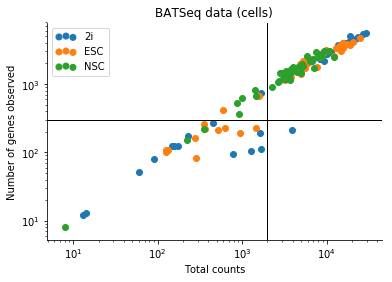

In [36]:
plt.loglog()
for n, g in sample_info.groupby('condition'):
    plt.scatter(g.total_counts, g.num_genes, label=n)
    
plt.legend(scatterpoints=3);
plt.axhline(300, lw=1, c='k');
plt.axvline(2000, lw=1, c='k');
plt.xlabel('Total counts')
plt.ylabel('Number of genes observed');
plt.title('BATSeq data (cells)');

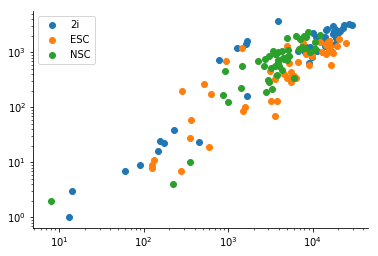

In [37]:
plt.loglog()
for n, g in sample_info.groupby('condition'):
    plt.scatter(g.total_counts, g.ERCC, label=n)
    
plt.legend();

In [38]:
sample_info = sample_info.query('total_counts > 2000 & num_genes > 300')
counts = counts[sample_info.index]

In [24]:
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(100).index

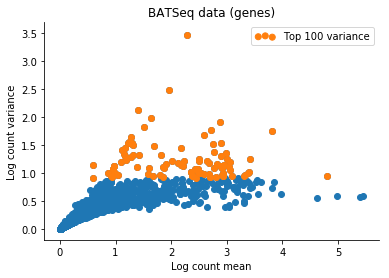

In [39]:
mus = counts.pipe(np.log1p).mean(1)
vas = counts.pipe(np.log1p).var(1)
plt.scatter(mus, vas, label='');
plt.scatter(mus[idx], vas[idx], label='Top 100 variance');
plt.legend(scatterpoints=3)
plt.xlabel('Log count mean')
plt.ylabel('Log count variance');
plt.title('BATSeq data (genes)');

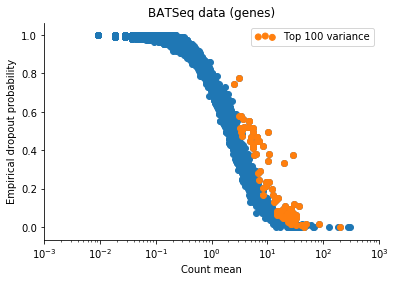

In [41]:
plt.xscale('log')
plt.scatter(counts.mean(1), 1 - (counts > 1).sum(1) / counts.shape[1]);
plt.scatter(counts.mean(1)[idx], (1 - (counts > 1).sum(1) / counts.shape[1])[idx], label='Top 100 variance');
plt.legend(scatterpoints=3)
plt.xlim(1e-3, 1e3);
plt.xlabel('Count mean')
plt.ylabel('Empirical dropout probability');
plt.title('BATSeq data (genes)');

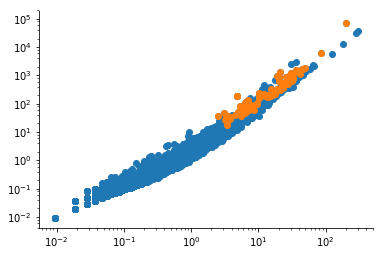

In [104]:
plt.loglog()
plt.scatter(counts.mean(1), counts.var(1));
plt.scatter(counts.mean(1)[idx], counts.var(1)[idx]);

In [42]:
counts.shape

(44034, 107)

In [84]:
import patsy

Y = patsy.dmatrix('np.log(ERCC) + 1', sample_info, return_type='dataframe')
y = np.asarray(Y)

hv_counts = counts.loc[idx]

Y_ = Y.join(pd.DataFrame({'cell': Y.index}, index=Y.index))
long_data = pd.melt(hv_counts.T.join(Y_), id_vars=Y_.columns.tolist()).dropna()
covars = long_data.drop(['variable', 'value', 'cell'], 1)
genes = long_data.variable.astype('category')
cells = long_data.cell.astype('category')
y = long_data.value.values

In [85]:
import pickle

with open('zinb-wave.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [86]:
N = y.shape[0]
P = covars.shape[1]
G = genes.cat.categories.shape[0]
C = cells.cat.categories.shape[0]
data = {
    'N': N,
    'P': P,
    'K': 2,
    'G': G,
    'C': C,
    'x': covars.values,
    'y': y,
    'gene': genes.cat.codes.values + 1,
    'cell': cells.cat.codes.values + 1
}

In [96]:
v = model.vb(data=data, iter=3000)

In [97]:
res = pd.read_csv(v['args']['sample_file'].decode('ascii'), comment='#').dropna()
resm = res.mean()

/Users/vs4/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [98]:
v_w = resm[resm.index.str.startswith('w.')]

df_v_w = v_w.index.str.extract('w\.(\d+)\.(\d+)', expand=True).astype(int)
df_v_w.columns = ['dim', 'cell']
df_v_w['value'] = v_w.values
w = df_v_w.pivot_table(values='value', columns=['dim'], index=['cell'])
w.index = cells.cat.categories[w.index - 1]

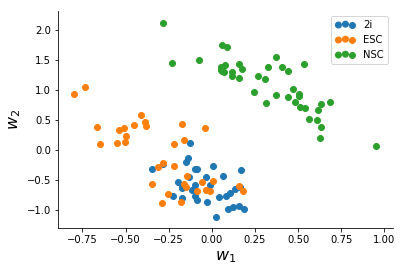

In [99]:
tmp = w.copy()
tmp['condition'] = sample_info.loc[tmp.index]['condition']

for n, g in tmp.groupby('condition'):
    plt.scatter(g[1], g[2], label=n);
    
plt.legend(scatterpoints=3);
plt.xlabel('$w_1$', size=16)
plt.ylabel('$w_2$', size=16);

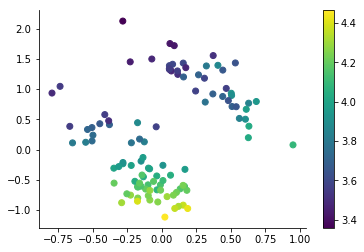

In [100]:
tmp = w.copy()
tmp['c'] = sample_info.loc[tmp.index]['total_counts']
plt.scatter(tmp[1], tmp[2], c=np.log10(tmp['c']));
plt.colorbar();

In [93]:
o = model.optimizing(data=data)

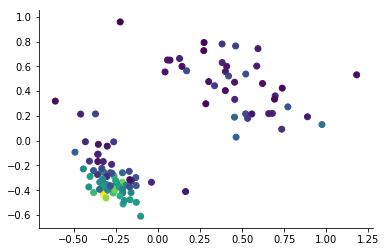

In [94]:
plt.scatter(*o['w'], c=tmp['c']);

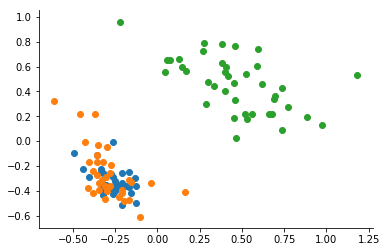

In [95]:
tmp = pd.DataFrame(o['w'].T, index=sample_info.index)
tmp['c'] = sample_info.loc[tmp.index]['condition']
for n, g in tmp.groupby('c'):
    plt.scatter(g[0], g[1]);